In [ ]:
from utils import *

NOTEBOOK_ID = '07'
RUN_MODELS = False
RUN_ENSEMBLING = False

In [3]:
df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl')
X = np.asarray([np.array(emb) for emb in df['esm2_t33_650M_UR50D']])
y = df['activity'].to_numpy()
threshold = df['activity'].median()

y_cont = y.reshape(-1, 1)
y_cont = preprocessing.StandardScaler().fit_transform(y_cont)
y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)

df['scaled_activity'] = y_cont

train, val, test, idx = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
(train_idx, val_idx, test_idx) = idx

X_train_val = torch.concatenate([X_train, X_val])
y_train_val = torch.concatenate([y_cont_train, y_cont_val])

train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
val_ds = TensorDataset(X_val.to(torch.float), y_cont_val.to(torch.float))

In [4]:
# import top performing models from parameter sweep results
top_df = pd.read_csv(f'{PARAMETER_DIR}/01-grid_search/03-results/parameter_sweep_results.csv').query('pearson >= 0.80')
metrics_df = pd.read_csv(f'{PARAMETER_DIR}//01-grid_search/03-results/metrics_df.csv')

In [5]:
if RUN_MODELS:
    file_dict = {}
    test_ds = TensorDataset(X_test.to(torch.float), y_cont_test.to(torch.float))
    for idx, row in tqdm(top_df.iterrows(),total=len(top_df)):
        model = ADhunterSystem_v2(
            embedding_size=X[0].shape[1],
            hidden=row['hidden_size'], 
            kernel_size=row['kernel_size'], 
            dilation=row['dilation'], 
            num_res_blocks=row['num_res_blocks'],
            )
        output_file = f"cnn_h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}"

        model.load_state_dict(torch.load(f'{HAMMING_ENSEMBLE_DIR}/02-models/{output_file}.pt'))
        test_dl = DataLoader(test_ds, batch_size=row['batch_size'])

        model.eval()
        X_test, y_test = test_ds[:]
        y_test = y_test.reshape(-1)
        with torch.no_grad():
            y_test_hat = model(X_test).reshape(-1)
            y_test_hat = y_test_hat.detach().numpy()
            y_test = y_test.numpy()

        best_thresh = get_threshold(y_bin_test, y_test_hat)
        best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
        y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

        y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
        y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
        pearson_corr = pearsonr(y_test_hat_unscaled, y_test_unscaled)[0]
        file_dict[ row['file'] ] = y_test_hat_bin
        test_df = pd.DataFrame([file_dict]).T.reset_index()
        test_df.columns = ['file','y_hat_test']
        test_df = test_df.set_index('file')
        test_df.to_pickle(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing.pkl')
else:
    test_df = pd.read_pickle(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing.pkl')
test_df

test_df = test_df['y_hat_test'].apply(pd.Series).sort_index(ascending=False)
num_ones_per_column = np.sum(test_df.to_numpy(), axis=0)
sorted_column_indices = np.argsort(num_ones_per_column)
test_df = test_df[sorted_column_indices]
df_filtered = test_df.loc[:, (test_df != 1).any(axis=0)]
df_filtered = df_filtered.loc[:, (df_filtered != 0).any(axis=0)]

In [6]:
if RUN_MODELS:
    selected_arrays, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 30)
    hits_df = df_filtered.reset_index()
    hits_df = hits_df.loc[selected_indices].set_index('file')
    for state in range(1,4):
        for idx, row in top_df[top_df.file.isin(hits_df.index)].iterrows():
            output_file = f"h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}"
            dataset, _ = split_dataset(X,y,threshold,version='v2',scaler='standard',random_state=state)
            train_ADhunter(dataset,out_dir=f'{HAMMING_ENSEMBLE_DIR}/04-ensemble_size',out_name=output_file,version='v2',random_state=state,
                        hidden_size=row['hidden_size'],kernel_size=row['kernel_size'],dilation=row['dilation'],num_res_blocks=row['num_res_blocks'],batch_size=row['batch_size'])
            test_ADhunter(dataset,out_dir=f'{HAMMING_ENSEMBLE_DIR}/04-ensemble_size',out_name=output_file,version='v2',random_state=state,
                        hidden_size=row['hidden_size'],kernel_size=row['kernel_size'],dilation=row['dilation'],num_res_blocks=row['num_res_blocks'])

In [ ]:
_, ensemble_test_df = parse_results(f'{HAMMING_ENSEMBLE_DIR}/04-ensemble_size/03-results')
ensemble_test_df = ensemble_test_df[ensemble_test_df['params'].apply(lambda x: 'dedup' not in x)]
ensemble_test_df['state'] = ensemble_test_df['params'].apply(lambda x: x.split('_state')[-1])
ensemble_test_df['params'] = ensemble_test_df['params'].apply(lambda x: x.replace('ADhunter_v2-',''))
ensemble_test_df['file'] = ensemble_test_df['params'].apply(lambda x: x.split('_state')[0])
ensemble_test_df['datapoint'] = list(range(1761)) * len(ensemble_test_df['params'].unique())

ensemble_df = None
for i in range(1,31):
    selected_arrays, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), i)
    hits_df = df_filtered.reset_index()
    hits_df['file'] = hits_df['file'].apply(lambda x: x.replace('cnn_',''))
    models = hits_df.loc[selected_indices,'file'].to_list()
    tmp_df = ensemble_test_df[ensemble_test_df['file'].isin(models)]
    tmp_df = tmp_df.groupby(['state','datapoint'])[['y_test_hat','y_test']].mean().reset_index().groupby('state').agg(lambda x: list(x))
    tmp_df['pearson_corr'] = tmp_df.apply(lambda x: pearsonr(x['y_test_hat'],x['y_test'])[0],axis=1)
    tmp_df['spearman_corr'] = tmp_df.apply(lambda x: spearmanr(x['y_test_hat'],x['y_test'])[0],axis=1)
    tmp_df['rmse'] = tmp_df.apply(lambda x: mean_squared_error(x['y_test_hat'],x['y_test'],squared=False),axis=1)
    tmp_df = tmp_df.drop(columns=['datapoint','y_test_hat','y_test']).reset_index()
    tmp_df['ensemble_size'] = i
    ensemble_df = pd.concat([ensemble_df,tmp_df]).reset_index(drop=True)
ensemble_df.drop(columns='state').groupby('ensemble_size').mean().style

,pearson_corr,spearman_corr,rmse
ensemble_size,,,
1,0.749111,0.754945,0.662175
2,0.762269,0.767264,0.648937
3,0.766169,0.771552,0.641903
4,0.768611,0.773954,0.638239
5,0.767942,0.773295,0.638522
6,0.769753,0.774649,0.636281
7,0.769251,0.774864,0.637142
8,0.768664,0.774179,0.638242
9,0.769167,0.774496,0.637914


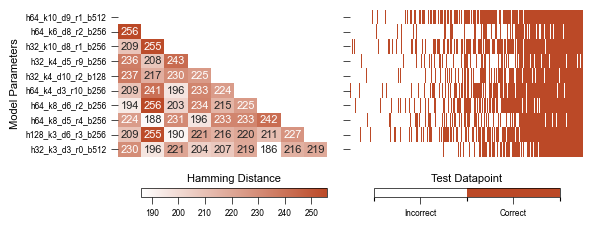

In [ ]:
fig = plt.figure(figsize=(6,6),constrained_layout=True)
gs = GridSpec(2,2,wspace=0)

ax1 = fig.add_subplot(gs[0,0])
selected_arrays, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 10)
hits_df = df_filtered.reset_index()
hits_df = hits_df.loc[selected_indices]
hits_df['file'] = hits_df['file'].apply(lambda x: x.replace('cnn_',''))
arrays = selected_arrays
labels=[x.replace('cnn_','') for x in df_filtered.index[selected_indices] ]
num_arrays = len(arrays)
distances = np.zeros((num_arrays, num_arrays))
for i in range(num_arrays):
    for j in range(num_arrays):
        distances[i, j] = hamming_distance(arrays[i], arrays[j])
mask = np.triu(np.ones_like(distances, dtype=bool))
colors = ["white", '#bb4927']
cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=1000)
g = sns.heatmap(distances,cbar=False, annot_kws={"fontsize":8}, cmap=cmap,annot=True, fmt=".0f", mask=mask,ax=ax1)
g.set(xlabel='Hamming Distance',ylabel='Model Parameters',yticklabels=hits_df['file'],xticklabels=['']*10)
ax1.tick_params(axis='x',bottom=False)
ax1.set_yticklabels(labels,rotation=0)
colorbar = fig.colorbar(g.collections[0],shrink=0.8, orientation='horizontal',pad=0.15)

ax2 = fig.add_subplot(gs[0,1])
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
boundaries = np.linspace(0, 1, 3)
norm = BoundaryNorm(boundaries, ncolors=256, clip=True)
g = sns.heatmap(hits_df.set_index('file'),cbar=False,norm=norm,cmap=cmap,ax=ax2)
g.set(xlabel='Test Datapoint',ylabel=None,xticklabels=['']*27,yticklabels=['']*10)
ax2.tick_params(axis='x',bottom=False)
colorbar = fig.colorbar(g.collections[0], ticks=[0.25, 0.75],shrink=0.8, orientation='horizontal',pad=0.15)
colorbar.set_ticklabels(['Incorrect','Correct'])

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hamming_ensemble.png',dpi=400,transparent=False,bbox_inches='tight')

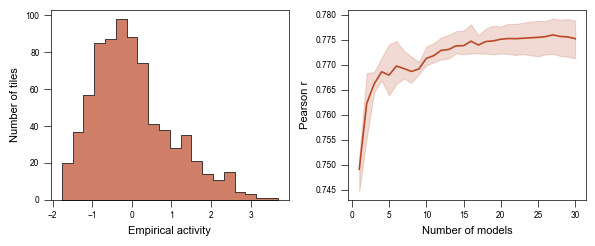

In [13]:
fig = plt.figure(figsize=(6,2.5))
gs = GridSpec(1,2)

ax3 = fig.add_subplot(gs[0,0])
tmp = df.loc[test_idx].reset_index(drop=True).loc[hits_df.set_index('file').columns]
g = sns.histplot(data=tmp,x='scaled_activity',ax=ax3,element='step',edgecolor='black',color='#bb4927',alpha=0.7,linewidth=0.5)
g.set(xlabel='Empirical activity',ylabel='Number of tiles')
ax4 = fig.add_subplot(gs[0,1])
g = sns.lineplot(data=ensemble_df,x='ensemble_size',y='pearson_corr',color='#bb4927',ax=ax4)
g.set(xlabel='Number of models',ylabel='Pearson r')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hamming_ensemble_size.png',dpi=400,transparent=False,bbox_inches='tight')